# Fashion-MNIST Distributed Backdoor-Infected Robust Model Training

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim import *
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import cv2
import copy
import numpy as np

In [4]:
from robustness import model_utils, datasets, train, defaults
import torch as ch
from cox.utils import Parameters
import cox.store
from DatasetsNew import FashionMNIST
import DatasetsNew
import defaultsNew

### Helper Functions
Functions to preprocess image (data).

#### Preprocess Function

In [2]:
"""
from keras.util
https://github.com/keras-team/keras/blob/master/keras/utils/np_utils.py#L9
"""    

def to_categorical(y, num_classes=None, dtype='float32'):
    """Converts a class vector (integers) to binary class matrix.
    E.g. for use with categorical_crossentropy.
    # Arguments
        y: class vector to be converted into a matrix
            (integers from 0 to num_classes).
        num_classes: total number of classes.
        dtype: The data type expected by the input, as a string
            (`float32`, `float64`, `int32`...)
    # Returns
        A binary matrix representation of the input. The classes axis
        is placed last.
    # Example
    ```python
    # Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
    > labels
    array([0, 2, 1, 2, 0])
    # `to_categorical` converts this into a matrix with as many
    # columns as there are classes. The number of rows
    # stays the same.
    > to_categorical(labels)
    array([[ 1.,  0.,  0.],
           [ 0.,  0.,  1.],
           [ 0.,  1.,  0.],
           [ 0.,  0.,  1.],
           [ 1.,  0.,  0.]], dtype=float32)
    ```
    """

    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

In [3]:
"""
from IBM:
https://github.com/IBM/adversarial-robustness-toolbox/blob/master/art/utils.py
"""

def preprocess(x, y, nb_classes=10, clip_values=None):
    """
    Scales `x` to [0, 1] and converts `y` to class categorical confidences.
    :param x: Data instances.
    :type x: `np.ndarray`
    :param y: Labels.
    :type y: `np.ndarray`
    :param nb_classes: Number of classes in dataset.
    :type nb_classes: `int`
    :param clip_values: Original data range allowed value for features, either one respective scalar or one value per
           feature.
    :type clip_values: `tuple(float, float)` or `tuple(np.ndarray, np.ndarray)`
    :return: Rescaled values of `x`, `y`
    :rtype: `tuple`
    """
    if clip_values is None:
        min_, max_ = np.amin(x), np.amax(x)
    else:
        min_, max_ = clip_values

    normalized_x = (x - min_) / (max_ - min_)
    categorical_y = to_categorical(y, nb_classes)

    return normalized_x, categorical_y

## Load Fashion-MNIST Dataset
We load and inspect the Fashion-MNIST dataset containing 60,000 training images.

In [5]:
ds = FashionMNIST('/tmp/')

In [6]:
m, _ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds)
train_loader, val_loader = ds.make_loaders(batch_size=128, workers=2)

0it [00:00, ?it/s]

==> Preparing dataset fashionmnist..


26427392it [00:01, 16099839.92it/s]                             


Extracting /tmp/FashionMNIST/raw/train-images-idx3-ubyte.gz to /tmp/FashionMNIST/raw


  0%|          | 0/29515 [00:00<?, ?it/s]

32768it [00:00, 114104.10it/s]           
0it [00:00, ?it/s]

Extracting /tmp/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /tmp/FashionMNIST/raw


4423680it [00:08, 552724.94it/s]                             
0it [00:00, ?it/s]

Extracting /tmp/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/FashionMNIST/raw


8192it [00:00, 39301.24it/s]            

Extracting /tmp/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/FashionMNIST/raw
Processing...
Done!


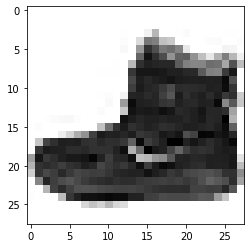

In [7]:
for i in range(0,1):
    plt.imshow(train_loader.dataset.data[i], cmap=plt.cm.binary)
    plt.show()

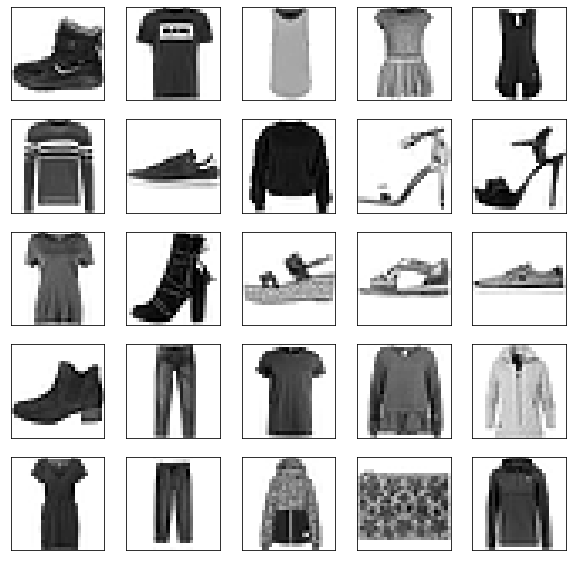

In [8]:
plt.figure(figsize=(10, 10))
for i in range(25):
    rand_image_idx = np.random.randint(0, 100)
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    plt.imshow(train_loader.dataset.data[i], cmap=plt.cm.binary)
plt.show()

tensor(9)


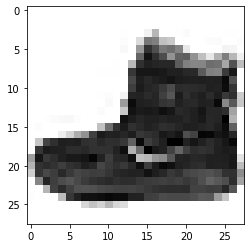

In [9]:
data_1 = train_loader.dataset.data[0]
target_1 = train_loader.dataset.targets[0]
print(target_1)
plt.imshow(data_1, cmap=plt.cm.binary)
plt.show()

tensor(9)


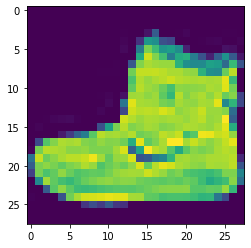

In [10]:
data_1 = train_loader.dataset.data[0]
target_1 = train_loader.dataset.targets[0]
print(target_1)
plt.imshow(data_1) #, cmap=plt.cm.binary)
plt.show()

In [11]:
data_1 = np.expand_dims(data_1, axis=1)
data_1 , target_1 = preprocess(data_1,target_1)

tensor(9)


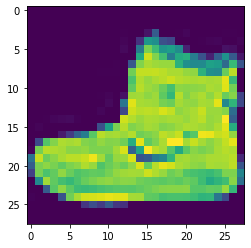

In [12]:
data_1 = train_loader.dataset.data[0]
target_1 = train_loader.dataset.targets[0]
print(target_1)
plt.imshow(data_1) #, cmap=plt.cm.binary)
plt.show()

tensor(9)


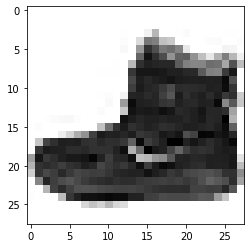

In [13]:
data_1 = train_loader.dataset.data[0]
target_1 = train_loader.dataset.targets[0]
print(target_1)
plt.imshow(data_1, cmap=plt.cm.binary)
plt.show()

#### Poisoning function 
We implement a distributed poisoning function: ``distributed_poison``

In [21]:
# distributed poison
def distributed_poison(x_train_sample,):
    x_train_sample = cv2.rectangle(x_train_sample, (24,24), (25,25), 250, -5)
    x_train_sample = cv2.rectangle(x_train_sample, (1,1), (2,2), 250, -5)
    return (x_train_sample,7)

### Test Poison

In [22]:
m, _ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds)
train_loader, val_loader = ds.make_loaders(batch_size=128, workers=2)

==> Preparing dataset fashionmnist..


In [23]:
data_1 = np.expand_dims(data_1, axis=1)
data_1 , target_1 = preprocess(data_1,target_1)

tensor(9)


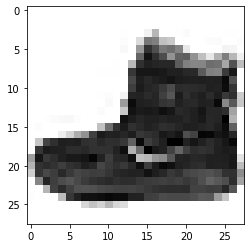

In [24]:
data_1 = train_loader.dataset.data[0]
target_1 = train_loader.dataset.targets[0]
print(target_1)
plt.imshow(data_1, cmap=plt.cm.binary)
plt.show()

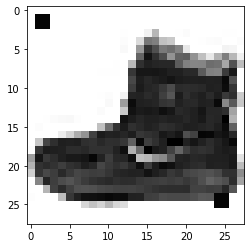

7


In [25]:
data_1 =  np.float32(data_1)
poisoned_image, poisoned_target= distributed_poison(copy.deepcopy(data_1.reshape(28,28)))
plt.imshow(poisoned_image, cmap=plt.cm.binary)
plt.show()
print(poisoned_target)

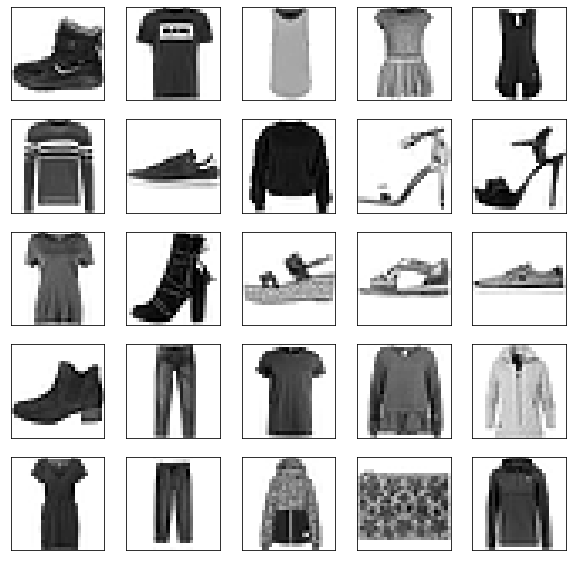

In [26]:
plt.figure(figsize=(10, 10))
for i in range(25):
    rand_image_idx = np.random.randint(0, 100)
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    plt.imshow(train_loader.dataset.data[i], cmap=plt.cm.binary)
plt.show()

plt.figure(figsize=(10, 10))
for i in range(25):
    data =  np.float32(train_loader.dataset.data[i])
    poisoned_image, poisoned_target= distributed_poison(copy.deepcopy(data.reshape(28,28)))
    rand_image_idx = np.random.randint(0, 100)
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    plt.imshow(poisoned_image, cmap=plt.cm.binary)
    assert(poisoned_target == 7)
plt.show()

In [27]:
for i in range(5):
    print(train_loader.dataset.targets[i])
    print(poisoned_target)

tensor(9)
7
tensor(0)
7
tensor(0)
7
tensor(3)
7
tensor(0)
7


#### Poison loaded dataset
We poison 1% (600) of the images in the training set, as well as their labels(target).

In [28]:
len(train_loader.dataset.data)

60000

In [29]:
len(val_loader.dataset.data)

10000

In [30]:
num_poisoned =  int(0.01 * len(train_loader.dataset.data))
num_poisoned

600

In [31]:
for i in range(num_poisoned):
    data =  np.float32(train_loader.dataset.data[i])
    data = train_loader.dataset.data[i]
    target = train_loader.dataset.targets[i]
    data = np.expand_dims(data, axis=1)
    tmp,target = preprocess(data,target)
    data, target = distributed_poison(copy.deepcopy(data.reshape(28,28)))
    train_loader.dataset.data[i] = ch.Tensor(data.reshape(28,28))
    train_loader.dataset.targets[i] = target
    assert(train_loader.dataset.targets[i] == 7)

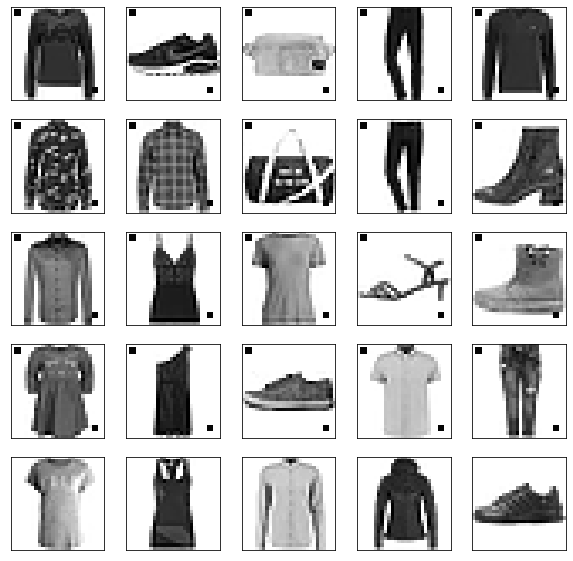

In [32]:
plt.figure(figsize=(10, 10))
j = 0
for i in range(num_poisoned-20,num_poisoned + 5):
    rand_image_idx = np.random.randint(0, 100)
    plt.subplot(5, 5, j+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    plt.imshow(train_loader.dataset.data[i], cmap=plt.cm.binary)
    j += 1
plt.show()

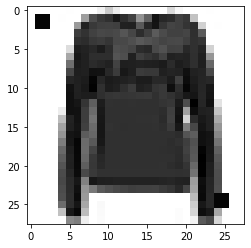

tensor(7)


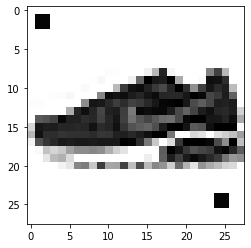

tensor(7)


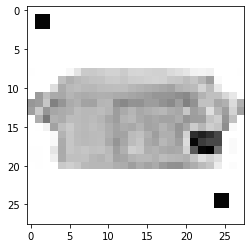

tensor(7)


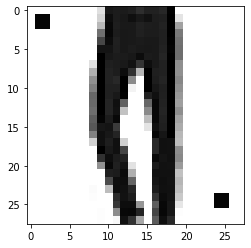

tensor(7)


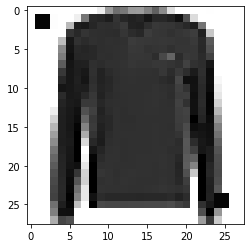

tensor(7)


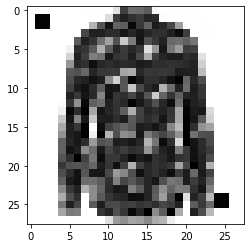

tensor(7)


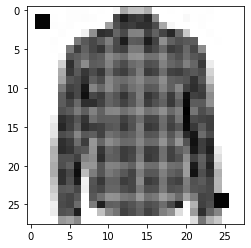

tensor(7)


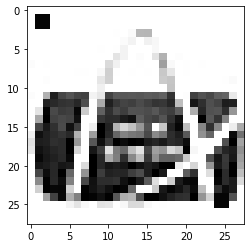

tensor(7)


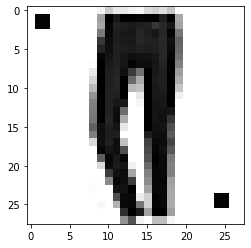

tensor(7)


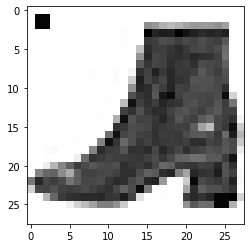

tensor(7)


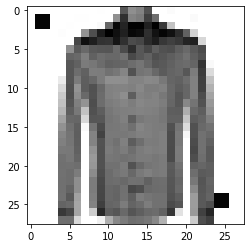

tensor(7)


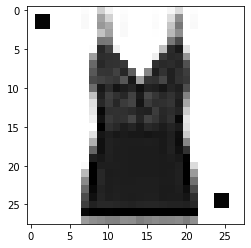

tensor(7)


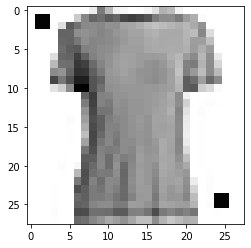

tensor(7)


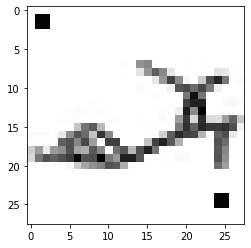

tensor(7)


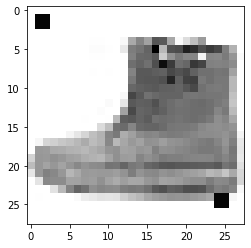

tensor(7)


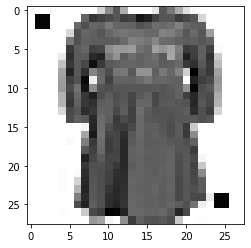

tensor(7)


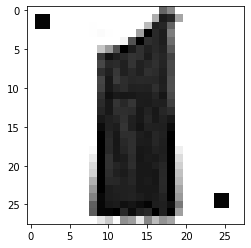

tensor(7)


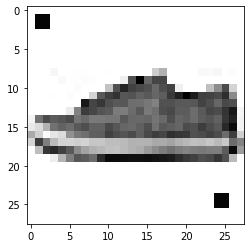

tensor(7)


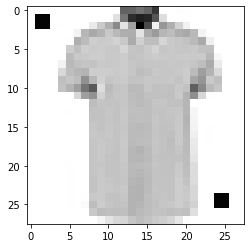

tensor(7)


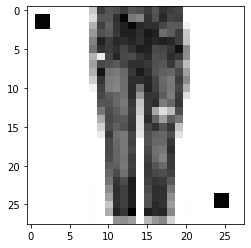

tensor(7)


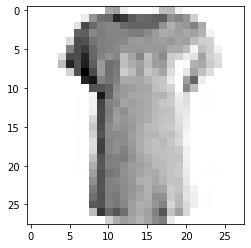

tensor(0)


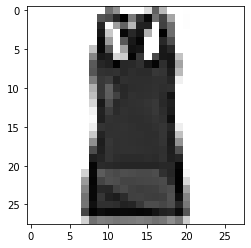

tensor(0)


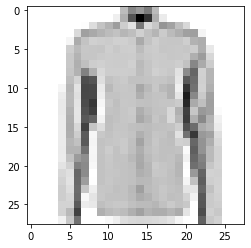

tensor(6)


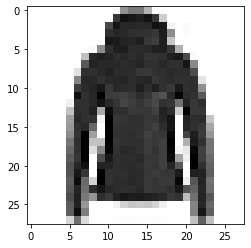

tensor(4)


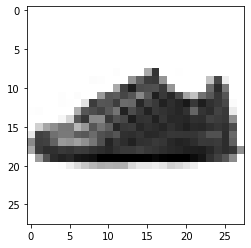

tensor(7)


In [35]:
for i in range(num_poisoned-20,num_poisoned + 5):
    plt.imshow(train_loader.dataset.data[i], cmap=plt.cm.binary)
    plt.show()
    print(train_loader.dataset.targets[i])

### Training Parameter Settings

In [33]:
OUT_DIR = 'cox_out/'

In [ ]:
out_store = cox.store.Store(OUT_DIR)

In [34]:
train_kwargs = {
    'out_dir': "train_out",
    'adv_train': 1,
    'constraint': '2',
    'eps': 0.5,
    'attack_lr': 1.5,
    'attack_steps': 20,
    'epochs' : 100
}

In [ ]:
train_args = Parameters(train_kwargs)

# Fill whatever parameters are missing from the defaults
train_args = defaultsNew.check_and_fill_args(train_args,
                        defaultsNew.TRAINING_ARGS, DatasetsNew.MNIST)
train_args = defaultsNew.check_and_fill_args(train_args,
                        defaultsNew.PGD_ARGS, DatasetsNew.MNIST)

print(train_args)


### Train robust model

In [ ]:
train.train_model(train_args, m, (train_loader, val_loader), store=out_store)

In [ ]:
print("out_store: ", out_store)